# Import Packages 

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import datetime,warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
%matplotlib inline

sns.set()

In [80]:
df_raw= pd.read_csv("data_3_train.csv")
df_test_raw = pd.read_csv("data_3_test.csv")

In [81]:
df_raw = df_raw[~df_raw['Account Name: Account Name'].str.contains("DO NOT USE" or "do not use" or "Do not use" or "ChargePoint Webstore (Old - Do not use)")]

In [83]:
# Remove outlier
df_raw = df_raw[df_raw['sum'] <= 9999999]
info = df_raw['Account Name: Account Name']

In [84]:
df = df_raw.drop(['Unnamed: 0','Account Name: Account Name', 'count'], axis=1)
df_test = df_test_raw.drop(['Unnamed: 0','Account Name: Account Name', 'count'], axis=1)

In [85]:
df.head()

,Order_Won,min,max,mean,sum,Bundle,Cloud : New,Cloud : Renewal,Hardware : FRUs,Hardware : Stations,Other Services : CPaaS,Other Services : Validation,Other Support Services : Activation,Warranty : Assure,Warranty : Assure Renewal,LastPurchase,FirstPurchase,output(kW)
0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,412,412,0.0
1,11,0.0,305484.0,73911.923077,960855.0,11.0,128130.0,0.0,1710.0,570807.5,0.0,4200.0,1047.0,230912.0,0.0,118,443,706.6
2,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320,320,0.0
3,5,4238.0,101318.0,28739.600000,143698.0,0.0,30578.0,0.0,0.0,65280.0,0.0,0.0,0.0,46310.0,0.0,328,373,62.5
4,1,382372.0,382372.0,382372.000000,382372.0,0.0,25196.0,0.0,0.0,94608.0,0.0,0.0,0.0,49614.0,0.0,282,282,1100.0


## Customer Segmentation (K-means Modeling)

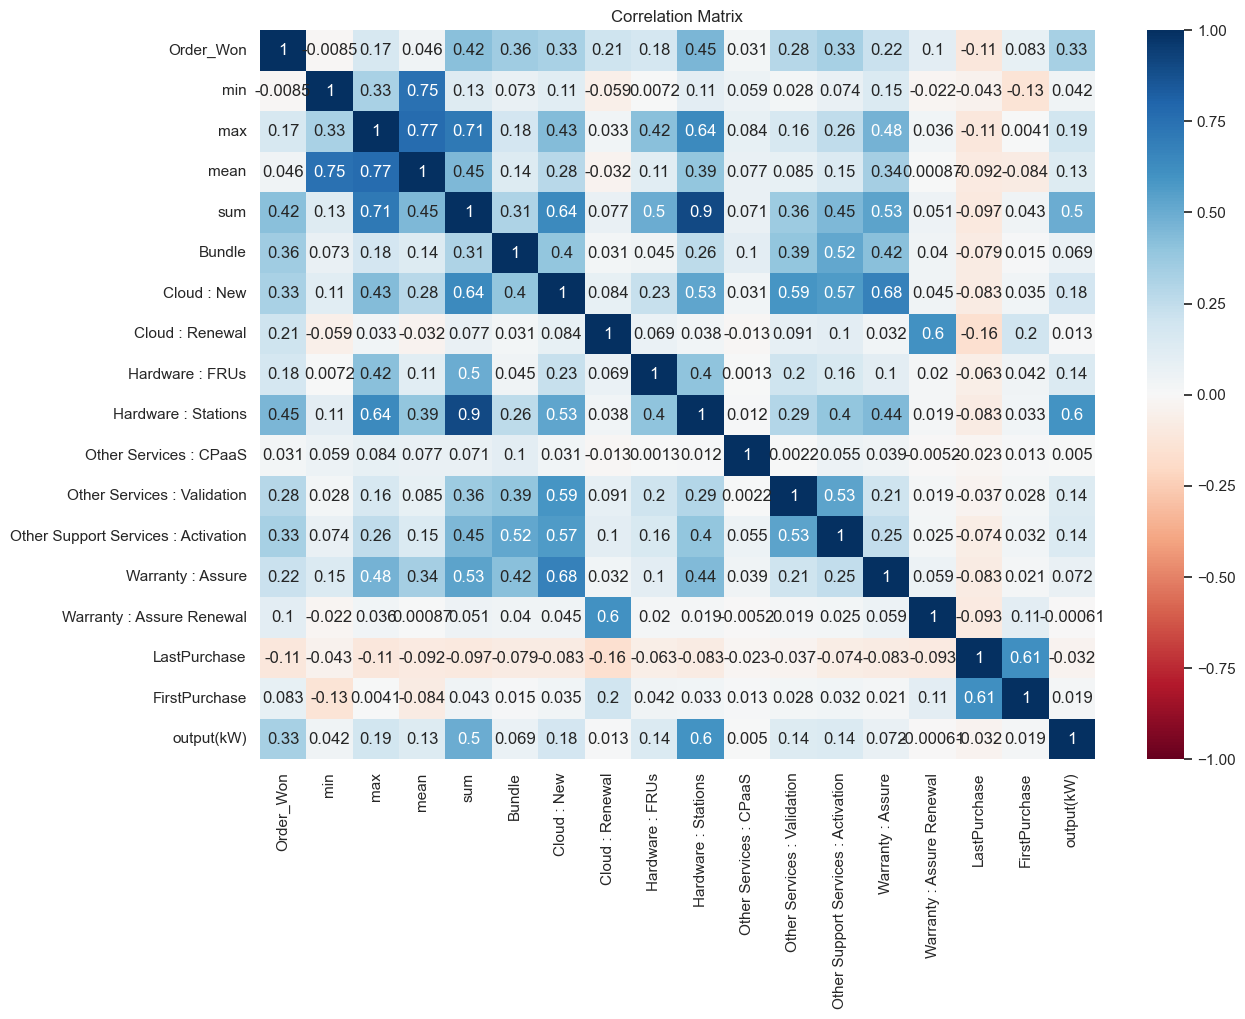

In [86]:
plt.figure(figsize=(12, 9))
s = sns.heatmap(df.corr(),
                annot=True,
                cmap='RdBu',
                vmin=-1,
                vmax=1)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.title('Correlation Matrix')
plt.show()

In [87]:
scaler = StandardScaler()
customers_std = scaler.fit_transform(df)

In [88]:
results = {}

for i in range (1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(customers_std)
    results[i] = kmeans.inertia_

In [89]:
results

{1: 436698.0,
 2: 366521.70340058254,
 3: 332635.4586397504,
 4: 305105.99651679595,
 5: 287915.3603875318,
 6: 261363.439230197,
 7: 247195.82830338264,
 8: 236497.88104638256,
 9: 220226.5701199894,
 10: 208725.91998839285}

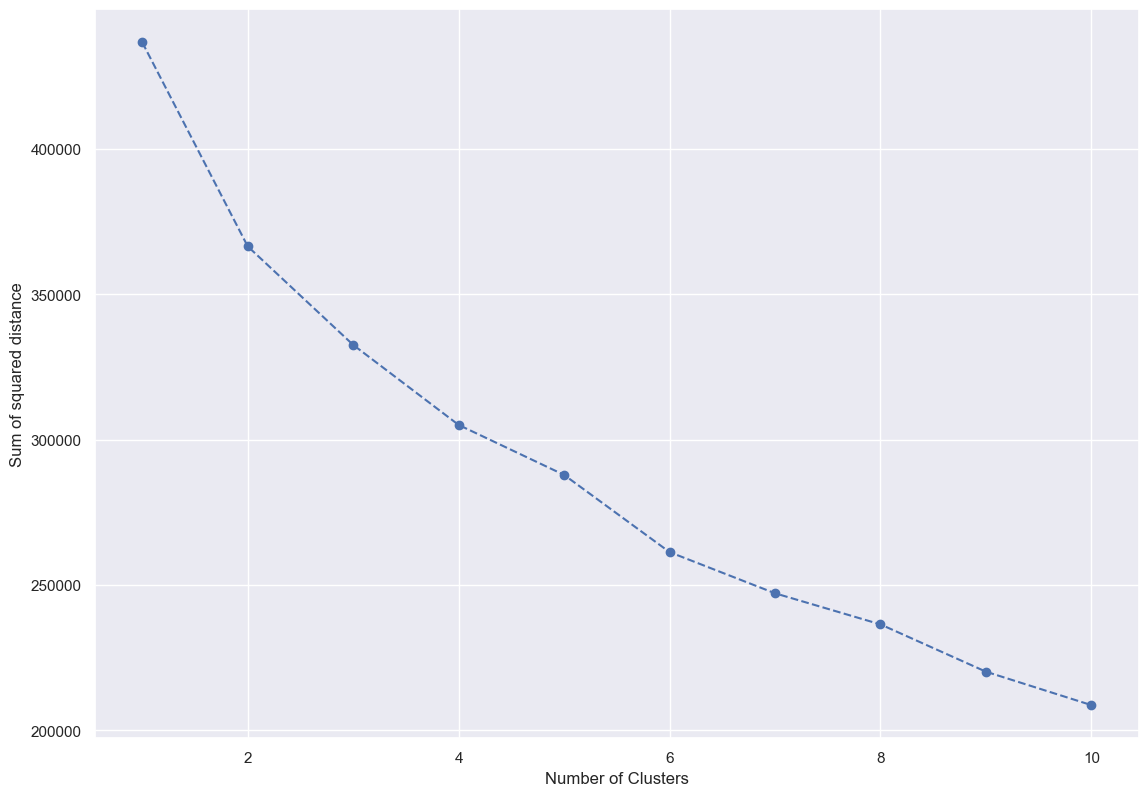

In [90]:
plt.figure(figsize=(12, 9))
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='--')

plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distance')
plt.show()

In [91]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(customers_std)

pca.explained_variance_ratio_

array([0.28454022, 0.11407126, 0.08937014, 0.08829243, 0.08075965,
       0.05723544, 0.05430904, 0.05029077, 0.03827271, 0.03073054,
       0.02698607, 0.02214678, 0.02154718, 0.0146692 , 0.01111626,
       0.00850778, 0.00407148, 0.00308306])

Text(0, 0.5, 'Cumulative Explained Variance')

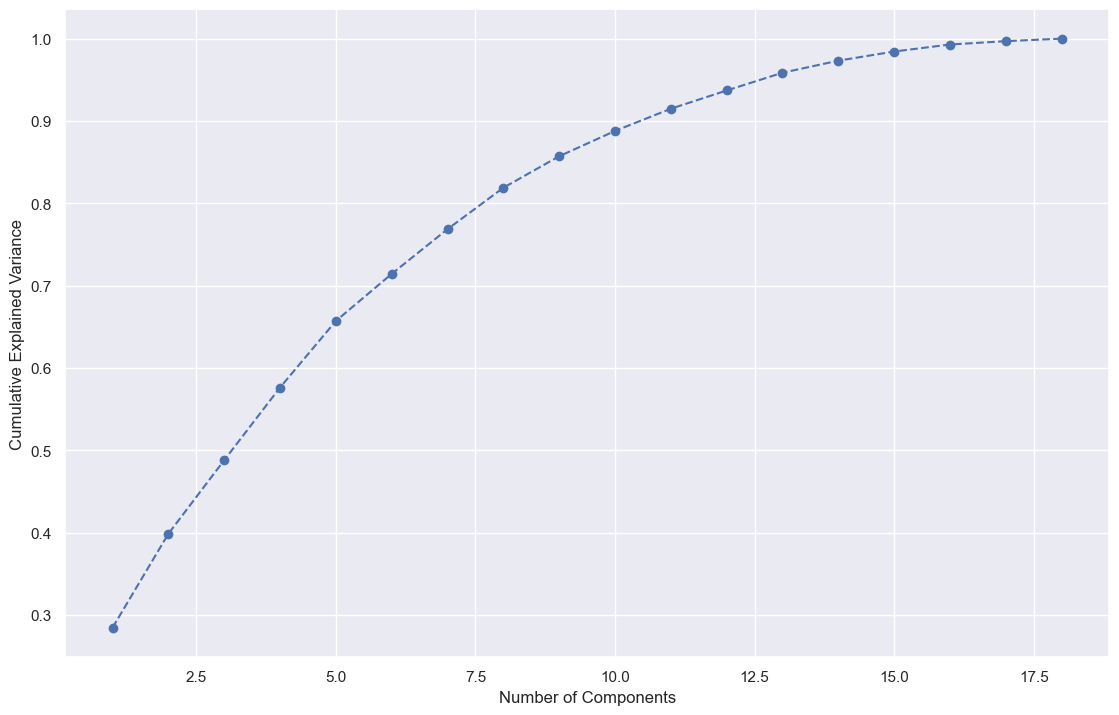

In [92]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 19), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [93]:
pca = PCA(n_components=6)
pca.fit(customers_std)

df_pca_components = pd.DataFrame(
    data=pca.components_.round(4),
    columns=df.columns.values,
    index=['component 1', 'component 2', 'component 3','component 4','component 5','component 6'])

df_pca_components

,Order_Won,min,max,mean,sum,Bundle,Cloud : New,Cloud : Renewal,Hardware : FRUs,Hardware : Stations,Other Services : CPaaS,Other Services : Validation,Other Support Services : Activation,Warranty : Assure,Warranty : Assure Renewal,LastPurchase,FirstPurchase,output(kW)
component 1,0.2275,0.1245,0.3293,0.2472,0.3999,0.2256,0.3442,0.0565,0.1945,0.3716,0.0380,0.2346,0.2703,0.2855,0.0383,-0.0693,0.0083,0.1937
component 2,0.2621,-0.4532,-0.2893,-0.4755,-0.0148,0.1832,0.1239,0.3139,0.0103,-0.0137,-0.0481,0.2491,0.2181,-0.0325,0.2430,0.1167,0.2851,0.0360
component 3,0.0457,0.0898,-0.0460,0.0356,-0.1114,0.1030,0.0168,0.3675,-0.1068,-0.1449,0.0195,0.0339,0.0564,0.0317,0.3744,-0.6241,-0.4820,-0.1674
component 4,-0.0105,-0.0836,-0.1990,-0.1665,-0.0982,0.3114,0.1828,-0.4721,-0.1670,-0.1063,0.0345,0.2767,0.2673,0.0799,-0.4854,-0.1268,-0.3164,-0.1271
component 5,0.1573,-0.3144,-0.0368,-0.2408,0.1846,-0.2543,-0.1547,-0.1255,0.2798,0.2769,-0.1309,-0.1188,-0.1467,-0.2234,-0.1638,-0.3131,-0.3211,0.4394
component 6,0.3249,0.1842,-0.1481,0.0608,-0.0404,0.1841,-0.2045,-0.0006,-0.3491,0.0547,0.6522,-0.1164,0.0388,-0.1878,0.0001,0.0211,0.0319,0.3943


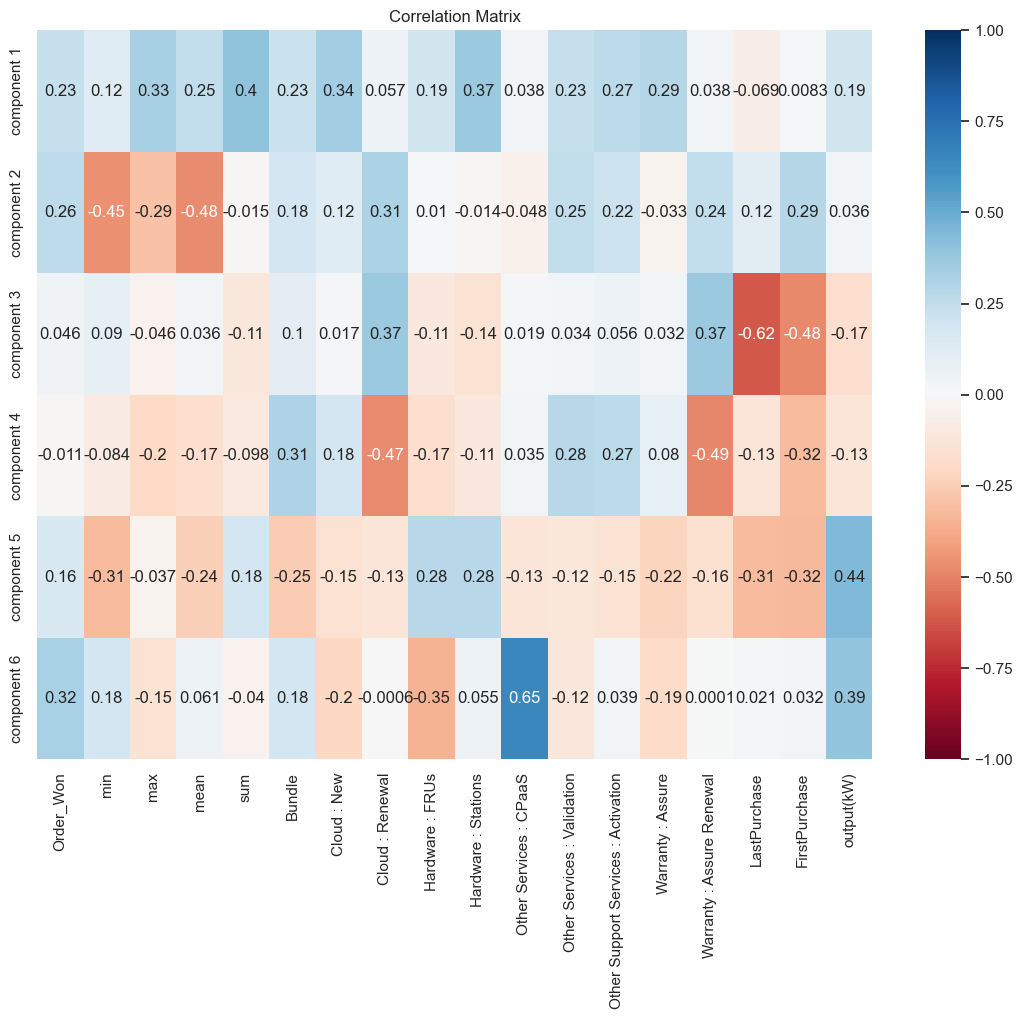

In [94]:
plt.figure(figsize=(12, 9))
s = sns.heatmap(
    df_pca_components,
    vmin=-1,
    vmax=1,
    cmap='RdBu',
    annot=True
)
plt.title('Correlation Matrix')
plt.show()

In [95]:
pca_scores = pca.transform(customers_std)

results = {}

for i in range(1, 11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(pca_scores)   # pca_scores are standarzied by default
    results[i] = kmeans_pca.inertia_

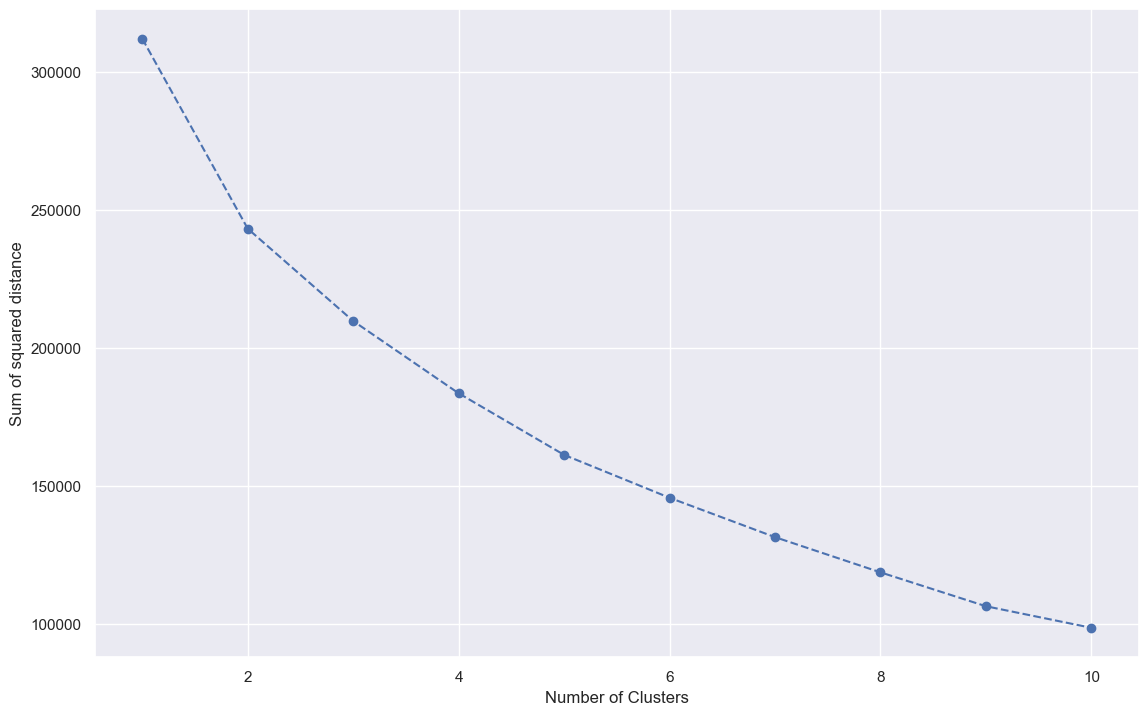

In [96]:
plt.figure(figsize=(12, 8))
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distance')
plt.show()

In [97]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_pca.fit(pca_scores)

KMeans(n_clusters=4, random_state=42)

In [98]:
df_segm_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(pca_scores)], axis=1)
df_segm_pca.columns.values[-6:] = ['component 1', 'component 2', 'component 3', 'component 4', 'component 5', 'component 6']
df_segm_pca['K-means PCA'] = kmeans_pca.labels_
df['K-means PCA'] = kmeans_pca.labels_

df_segm_pca

,Order_Won,min,max,mean,sum,Bundle,Cloud : New,Cloud : Renewal,Hardware : FRUs,Hardware : Stations,Other Services : CPaaS,Other Services : Validation,Other Support Services : Activation,Warranty : Assure,Warranty : Assure Renewal,LastPurchase,FirstPurchase,output(kW),component 1,component 2,component 3,component 4,component 5,component 6,K-means PCA
0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,412,412,0.0,-0.640703,0.155384,-0.685209,0.110360,0.020845,-0.119000,2
1,11,0.0,305484.0,73911.923077,960855.0,11.0,128130.0,0.0,1710.0,570807.5,0.00,4200.0,1047.0,230912.0,0.0,118,443,706.6,16.908528,-0.300541,-0.088966,2.725511,-3.518037,-4.315583,1
2,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,320,320,0.0,-0.604375,-0.074673,-0.043568,0.364067,0.387504,-0.149456,0
3,5,4238.0,101318.0,28739.600000,143698.0,0.0,30578.0,0.0,0.0,65280.0,0.00,0.0,0.0,46310.0,0.0,328,373,62.5,2.809043,-0.703081,-0.292562,0.234957,-0.694908,-1.111868,0
4,1,382372.0,382372.0,382372.000000,382372.0,0.0,25196.0,0.0,0.0,94608.0,0.00,0.0,0.0,49614.0,0.0,282,282,1100.0,10.690653,-17.530374,1.797344,-4.634351,-9.293395,2.530812,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24256,1,22090.9,22090.9,22090.900000,22090.9,1.0,0.0,0.0,0.0,0.0,4418.18,0.0,0.0,0.0,0.0,526,526,44.4,0.080426,-0.574857,-1.282218,-0.296974,-1.397711,1.960958,2
24257,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,565,565,0.0,-0.701117,0.537979,-1.752287,-0.311565,-0.588927,-0.068350,2
24258,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,595,595,0.0,-0.712963,0.612998,-1.961517,-0.394296,-0.708490,-0.058419,2
24259,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,504,504,0.0,-0.677030,0.385441,-1.326850,-0.143346,-0.345815,-0.088544,2


In [99]:
df_segm_pca['Name'] = info.tolist()

In [100]:
# have a look of the cluster
df_segm_pca[df_segm_pca['K-means PCA'] == 2]

,Order_Won,min,max,mean,sum,Bundle,Cloud : New,Cloud : Renewal,Hardware : FRUs,Hardware : Stations,Other Services : CPaaS,Other Services : Validation,Other Support Services : Activation,Warranty : Assure,Warranty : Assure Renewal,LastPurchase,FirstPurchase,output(kW),component 1,component 2,component 3,component 4,component 5,component 6,K-means PCA,Name
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,412,412,0.0,-0.640703,0.155384,-0.685209,0.110360,0.020845,-0.119000,2,"""An der Alten Försterei"" Stadionsbetriebs AG"
6,1,0.0,1039.0,519.5,1039.0,0.0,345.0,0.0,0.0,0.0,0.00,0.0,349.0,0.0,0.0,222,650,0.0,-0.422086,0.509666,-0.605876,-0.136764,-0.084692,-0.047060,2,*STRATEGIC* Starwood Hotels & Resorts Worldwid...
10,1,4283.2,4283.2,4283.2,4283.2,0.0,0.0,884.0,0.0,0.0,0.00,0.0,0.0,2515.2,0.0,323,323,0.0,-0.312863,0.372891,0.671908,-0.600432,0.016210,-0.094018,2,0813212 B.C. Ltd. c/o GWL Realty Advisors Inc.
11,1,0.0,7512.0,3756.0,7512.0,1.0,560.0,0.0,54.5,5408.0,0.00,509.0,297.0,629.0,0.0,534,587,7.2,-0.299436,0.667792,-1.635396,-0.131174,-0.739866,0.022507,2,1 AMD Place
13,1,3176.0,3176.0,3176.0,3176.0,0.0,0.0,60.0,0.0,0.0,0.00,0.0,0.0,0.0,689.0,582,582,0.0,-0.549388,0.776226,-1.400178,-0.988590,-0.902663,0.014739,2,1 Hotel West Hollywood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24256,1,22090.9,22090.9,22090.9,22090.9,1.0,0.0,0.0,0.0,0.0,4418.18,0.0,0.0,0.0,0.0,526,526,44.4,0.080426,-0.574857,-1.282218,-0.296974,-1.397711,1.960958,2,z-Spektrum Dental GmbH
24257,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,565,565,0.0,-0.701117,0.537979,-1.752287,-0.311565,-0.588927,-0.068350,2,École St-Émile
24258,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,595,595,0.0,-0.712963,0.612998,-1.961517,-0.394296,-0.708490,-0.058419,2,École de technologie supérieure
24259,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,504,504,0.0,-0.677030,0.385441,-1.326850,-0.143346,-0.345815,-0.088544,2,École primaire Mountainview Deux-Montagnes


In [101]:
df_segm_pca_analysis = df_segm_pca.groupby(['K-means PCA']).mean().round(4)
df_segm_pca_analysis

,Order_Won,min,max,mean,sum,Bundle,Cloud : New,Cloud : Renewal,Hardware : FRUs,Hardware : Stations,Other Services : CPaaS,Other Services : Validation,Other Support Services : Activation,Warranty : Assure,Warranty : Assure Renewal,LastPurchase,FirstPurchase,output(kW),component 1,component 2,component 3,component 4,component 5,component 6
K-means PCA,,,,,,,,,,,,,,,,,,,,,,,,
0,1.1710,4801.4555,11650.9826,7780.6965,1.433644e+04,0.5437,1297.7290,91.7059,255.2472,6.965669e+03,135.0143,137.7031,185.8631,1766.7431,54.6242,202.3247,243.5301,30.2246,-0.0797,-0.3839,0.8040,0.4929,0.5275,-0.0454
1,5.2295,82084.9383,199788.9934,117296.1906,3.448716e+05,2.9389,22439.6601,179.0860,4667.1735,1.631513e+05,1799.7595,2203.7294,1763.3881,33088.9726,156.4022,232.3526,356.5019,1378.2536,6.3658,-3.8590,0.4757,-0.8337,-2.0220,0.7545
2,1.3337,2539.1869,7360.1172,4449.1565,9.925234e+03,0.3752,841.8799,202.7036,261.8433,4.242654e+03,94.9886,116.0998,137.9715,916.7794,158.0271,409.9326,505.9393,18.1743,-0.2844,0.4609,-0.6718,-0.3736,-0.3610,0.0086
3,108.6500,304.0540,899060.7645,150374.2066,4.177548e+06,26.7500,265958.2566,726.4872,65740.5328,2.267085e+06,0.0000,26227.1205,25012.5649,276835.3875,914.1411,117.0500,543.6000,23507.5550,57.1095,8.5765,-5.0879,2.1147,7.2726,-1.5701


In [102]:
df_segm_pca_analysis['Count'] = df_segm_pca[['K-means PCA', 'min']].groupby(['K-means PCA']).count()
df_segm_pca_analysis['%'] = df_segm_pca_analysis['Count'] / df_segm_pca_analysis['Count'].sum()
df_segm_pca_analysis.rename(index={
    0: 'Potential Customer',
    1: 'Premium Customer',
    2: 'Inactive Customer',
    3: 'Priority Customer'
}, inplace=True)

pd.set_option('display.max_columns', None)
df_segm_pca_analysis

,Order_Won,min,max,mean,sum,Bundle,Cloud : New,Cloud : Renewal,Hardware : FRUs,Hardware : Stations,Other Services : CPaaS,Other Services : Validation,Other Support Services : Activation,Warranty : Assure,Warranty : Assure Renewal,LastPurchase,FirstPurchase,output(kW),component 1,component 2,component 3,component 4,component 5,component 6,Count,%
K-means PCA,,,,,,,,,,,,,,,,,,,,,,,,,,
Potential Customer,1.1710,4801.4555,11650.9826,7780.6965,1.433644e+04,0.5437,1297.7290,91.7059,255.2472,6.965669e+03,135.0143,137.7031,185.8631,1766.7431,54.6242,202.3247,243.5301,30.2246,-0.0797,-0.3839,0.8040,0.4929,0.5275,-0.0454,10687,0.440501
Premium Customer,5.2295,82084.9383,199788.9934,117296.1906,3.448716e+05,2.9389,22439.6601,179.0860,4667.1735,1.631513e+05,1799.7595,2203.7294,1763.3881,33088.9726,156.4022,232.3526,356.5019,1378.2536,6.3658,-3.8590,0.4757,-0.8337,-2.0220,0.7545,536,0.022093
Inactive Customer,1.3337,2539.1869,7360.1172,4449.1565,9.925234e+03,0.3752,841.8799,202.7036,261.8433,4.242654e+03,94.9886,116.0998,137.9715,916.7794,158.0271,409.9326,505.9393,18.1743,-0.2844,0.4609,-0.6718,-0.3736,-0.3610,0.0086,13018,0.536581
Priority Customer,108.6500,304.0540,899060.7645,150374.2066,4.177548e+06,26.7500,265958.2566,726.4872,65740.5328,2.267085e+06,0.0000,26227.1205,25012.5649,276835.3875,914.1411,117.0500,543.6000,23507.5550,57.1095,8.5765,-5.0879,2.1147,7.2726,-1.5701,20,0.000824


In [103]:
df_segm_pca_analysis_p = df_segm_pca_analysis[['sum', 'Bundle', 'LastPurchase',
       'FirstPurchase', 'output(kW)']]
df_segm_pca_analysis_p.columns = ['Total Purchase Amount', 'Number of Bundle', 'Dates from LastPurchase',
       'Dates from FirstPurchase', 'output(kW)']
df_segm_pca_analysis_p = df_segm_pca_analysis_p.loc[['Inactive Customer','Potential Customer','Premium Customer','Priority Customer']]
df_segm_pca_analysis_p      

,Total Purchase Amount,Number of Bundle,Dates from LastPurchase,Dates from FirstPurchase,output(kW)
K-means PCA,,,,,
Inactive Customer,9.925234e+03,0.3752,409.9326,505.9393,18.1743
Potential Customer,1.433644e+04,0.5437,202.3247,243.5301,30.2246
Premium Customer,3.448716e+05,2.9389,232.3526,356.5019,1378.2536
Priority Customer,4.177548e+06,26.7500,117.0500,543.6000,23507.5550


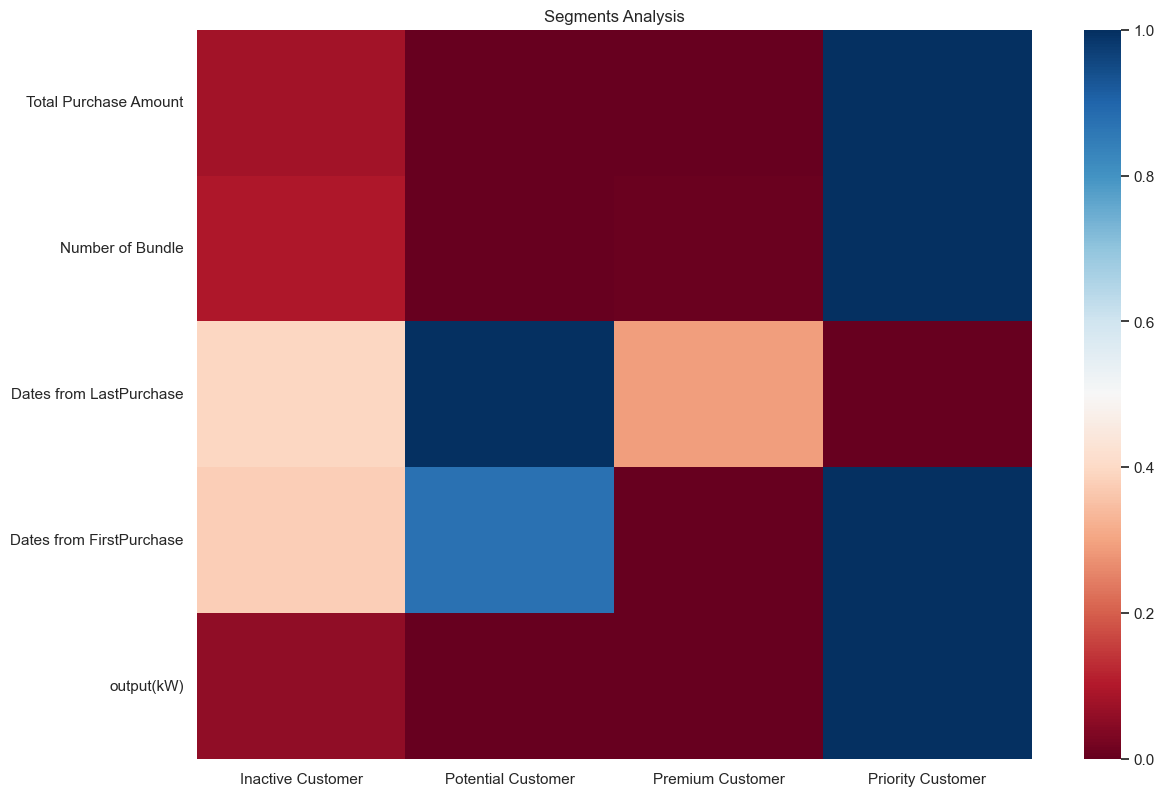

In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()
scaler2.fit(df_segm_pca_analysis_p)
df_segm_pca_analysis_plot = pd.DataFrame(scaler2.transform(df_segm_pca_analysis_p), columns = ['Total Purchase Amount', 'Number of Bundle', 'Dates from LastPurchase',
       'Dates from FirstPurchase', 'output(kW)'])
df_segm_pca_analysis_plot.rename(index={
    0: 'Potential Customer',
    1: 'Premium Customer',
    2: 'Inactive Customer',
    3: 'Priority Customer'
}, inplace=True)
df_segm_pca_analysis_plot = df_segm_pca_analysis_plot.loc[['Inactive Customer','Potential Customer','Premium Customer','Priority Customer']]


heatcmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(12, 9))
s = sns.heatmap(
    df_segm_pca_analysis_plot.T,
    vmin=0,
    vmax=1,
    cmap='RdBu',
)

plt.title('Segments Analysis')
plt.show()

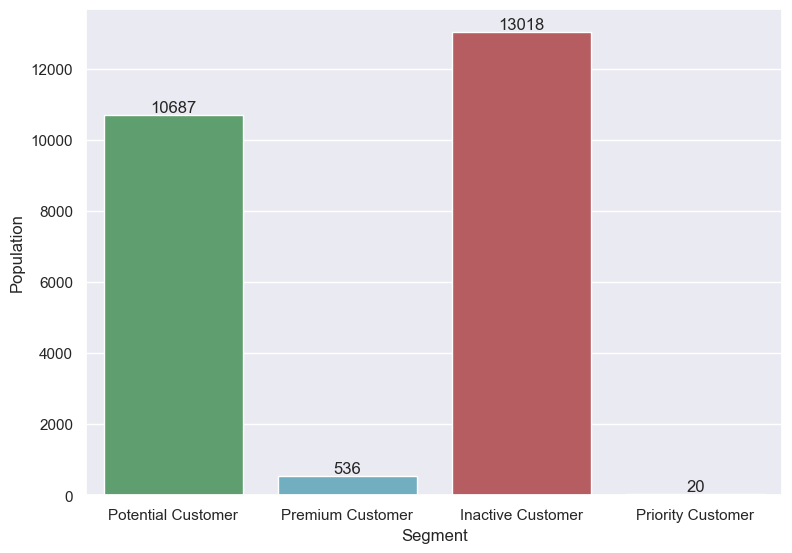

In [105]:
plt.figure(figsize=(8, 6))
s = sns.barplot(data=df_segm_pca_analysis, x=df_segm_pca_analysis.index, y='Count', palette=['g','c','r','m'])
plt.bar_label(s.containers[0])
plt.xlabel('Segment')
plt.ylabel('Population')
plt.show()

In [106]:
df_segm_pca['Segment'] = df_segm_pca['K-means PCA'].map({
    0: 'Potential Customer',
    1: 'Premium Customer',
    2: 'Inactive Customer',
    3: 'Priority Customer'
})
df_segm_pca

,Order_Won,min,max,mean,sum,Bundle,Cloud : New,Cloud : Renewal,Hardware : FRUs,Hardware : Stations,Other Services : CPaaS,Other Services : Validation,Other Support Services : Activation,Warranty : Assure,Warranty : Assure Renewal,LastPurchase,FirstPurchase,output(kW),component 1,component 2,component 3,component 4,component 5,component 6,K-means PCA,Name,Segment
0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,412,412,0.0,-0.640703,0.155384,-0.685209,0.110360,0.020845,-0.119000,2,"""An der Alten Försterei"" Stadionsbetriebs AG",Inactive Customer
1,11,0.0,305484.0,73911.923077,960855.0,11.0,128130.0,0.0,1710.0,570807.5,0.00,4200.0,1047.0,230912.0,0.0,118,443,706.6,16.908528,-0.300541,-0.088966,2.725511,-3.518037,-4.315583,1,#1 Cochran Automotive Group,Premium Customer
2,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,320,320,0.0,-0.604375,-0.074673,-0.043568,0.364067,0.387504,-0.149456,0,(add)ventures,Potential Customer
3,5,4238.0,101318.0,28739.600000,143698.0,0.0,30578.0,0.0,0.0,65280.0,0.00,0.0,0.0,46310.0,0.0,328,373,62.5,2.809043,-0.703081,-0.292562,0.234957,-0.694908,-1.111868,0,*STRATEGIC* CVS Health - HQ,Potential Customer
4,1,382372.0,382372.0,382372.000000,382372.0,0.0,25196.0,0.0,0.0,94608.0,0.00,0.0,0.0,49614.0,0.0,282,282,1100.0,10.690653,-17.530374,1.797344,-4.634351,-9.293395,2.530812,1,"*STRATEGIC* DownEast Renewable Energy, LLC",Premium Customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24256,1,22090.9,22090.9,22090.900000,22090.9,1.0,0.0,0.0,0.0,0.0,4418.18,0.0,0.0,0.0,0.0,526,526,44.4,0.080426,-0.574857,-1.282218,-0.296974,-1.397711,1.960958,2,z-Spektrum Dental GmbH,Inactive Customer
24257,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,565,565,0.0,-0.701117,0.537979,-1.752287,-0.311565,-0.588927,-0.068350,2,École St-Émile,Inactive Customer
24258,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,595,595,0.0,-0.712963,0.612998,-1.961517,-0.394296,-0.708490,-0.058419,2,École de technologie supérieure,Inactive Customer
24259,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,504,504,0.0,-0.677030,0.385441,-1.326850,-0.143346,-0.345815,-0.088544,2,École primaire Mountainview Deux-Montagnes,Inactive Customer


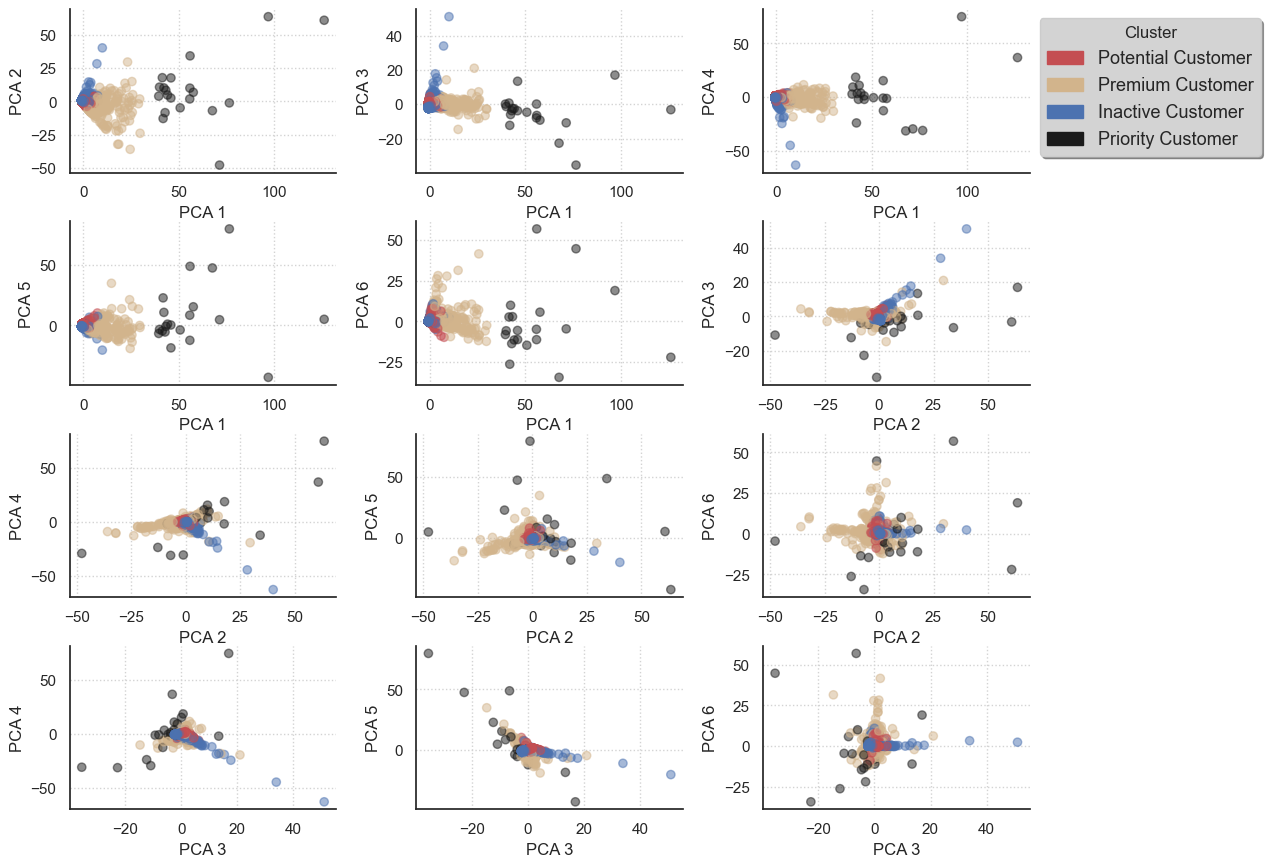

In [107]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k'}
label_color = [LABEL_COLOR_MAP[l] for l in df_segm_pca['K-means PCA']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(1,7):
    for iy in range(ix+1, 7):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(df_segm_pca['component '+ str(ix)], df_segm_pca['component '+ str(iy)], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
name = {0: 'Potential Customer',
    1: 'Premium Customer',
    2: 'Inactive Customer',
    3: 'Priority Customer'}
for i in range(4):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = name[i]))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

## Classification (Predictive Modeling)

In [108]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("f1_score: {:.2f} % ".format(100*metrics.f1_score(Y, self.predictions, average='weighted')))

In [109]:
columns = ['min', 'max', 'mean', 'sum', 'Bundle', 'Cloud : New', 'Cloud : Renewal',
       'Hardware : FRUs', 'Hardware : Stations', 'Other Services : CPaaS',
       'Other Services : Validation', 'Other Support Services : Activation',
       'Warranty : Assure', 'Warranty : Assure Renewal', 'LastPurchase',
       'FirstPurchase', 'output(kW)']
X = df[columns]
Y = df['K-means PCA']

In [110]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8, random_state=42, stratify=Y, shuffle=True)

In [111]:
SS_scaler = StandardScaler()
SS_scaler.fit(X_train)
X_train_ss= SS_scaler.transform(X_train)
X_test_ss= SS_scaler.transform(X_test)

Tree based models

In [112]:
# Decision Tree
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

f1_score: 96.88 % 


In [113]:
# Random Forest Classifier
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

f1_score: 98.73 % 


In [114]:
# Gradient Boosting Classifier
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

f1_score: 98.94 % 


Other Models

In [115]:
# Logistic Regression
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train_ss, Y = Y_train)
lr.grid_predict(X_test_ss, Y_test)

f1_score: 99.56 % 


In [116]:
# k-Nearest Neighbors
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train_ss, Y = Y_train)
knn.grid_predict(X_test_ss, Y_test)

f1_score: 98.11 % 


In [117]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [118]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best),('lr', lr_best)], voting='soft')  

In [119]:
votingC = votingC.fit(X_train, Y_train)
predictions = votingC.predict(X_test)
print("f1_score: {:.2f} % ".format(100*metrics.f1_score(Y_test, predictions, average='weighted')))

f1_score: 98.14 % 


## Test New Data

In [120]:
customers_test_std = scaler.transform(df_test)

pca_test_scores = pca.transform(customers_test_std)

In [121]:
test_Y = kmeans_pca.predict(pca_test_scores)

## Model test

In [122]:
columns = ['min', 'max', 'mean', 'sum', 'Bundle', 'Cloud : New', 'Cloud : Renewal',
       'Hardware : FRUs', 'Hardware : Stations', 'Other Services : CPaaS',
       'Other Services : Validation', 'Other Support Services : Activation',
       'Warranty : Assure', 'Warranty : Assure Renewal', 'LastPurchase',
       'FirstPurchase', 'output(kW)']
X_test = df_test[columns]
Y_test = test_Y

In [123]:
X_test_ss= SS_scaler.transform(X_test)

Tree based models

In [124]:
# Decision Tree
tr.grid_predict(X_test, Y_test)

f1_score: 99.26 % 


In [125]:
# Random Forest Classifier
rf.grid_predict(X_test, Y_test)

f1_score: 99.68 % 


In [126]:
# Gradient Boosting Classifier
gb.grid_predict(X_test, Y_test)

f1_score: 99.72 % 


Other Models

In [127]:
# Logistic Regression
lr.grid_predict(X_test_ss, Y_test)

f1_score: 99.72 % 


In [128]:
# k-Nearest Neighbors
knn.grid_predict(X_test_ss, Y_test)

f1_score: 99.30 % 


In [129]:
predictions = votingC.predict(X_test_ss)
print("f1_score: {:.2f} % ".format(100*metrics.f1_score(Y_test, predictions, average='weighted')))

f1_score: 95.88 % 
